In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle
import copy
from numba.typed import Dict
from numba.core import types
import networkx as nx

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc
from neurolib.control.optimal_control import cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/6n")
dir = pickledir

print(dir)

def plotspectrum(data, fmax=1., filename=None, vlines=None):

    ps_comp = None

    for d in data:
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)] / (len(ps)/2)
        ps_plot[0] = 0.
        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

        if ps_comp is None:
            ps_comp = ps_plot
        else:
            ps_comp += ps_plot

        plt.plot(fr, ps_plot)

    if vlines is not None:
        plt.vlines(vlines, 0, 1, color="gray", linestyle=":")

    plt.xlim(0,fmax)
    #plt.ylim(0,1.3*np.amax(ps_plot))
    #plt.ylim(0,0.5)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))
    
    plt.show()

    maxfreqind = np.where(ps_comp == max(ps_comp[1:]))
    print("freq of max = ", fr[maxfreqind])
    print("period of max = ", 1./fr[maxfreqind])

    return (1./fr[maxfreqind])[0]

def draw_nwgraph(cmat):
    G = nx.DiGraph() 
    for n in range(cmat.shape[0]):
            for l in range(cmat.shape[1]):
                if cmat[n,l] != 0:
                    G.add_edge(l,n)
    nx.draw(G, with_labels=True, arrows=True, **options)
    plt.show()

options = {
'node_color': 'lightgray',
'node_size': 1000,
'width': 2,
'arrowstyle': '-|>',
'arrowsize': 20,
'font_size' : 20,
'font_weight' : 'bold',
}

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/6n


In [22]:
N = 6

cmat = np.zeros((N,N) )
dmat = np.zeros((N,N) )

p = 0.4

for n1 in range(N):
    for n2 in range(N):
        if n1 == n2: continue
        if np.random.rand() < p:
            cmat[n1,n2] = 1
            dmat[n1,n2] = int(np.random.rand() * 20)

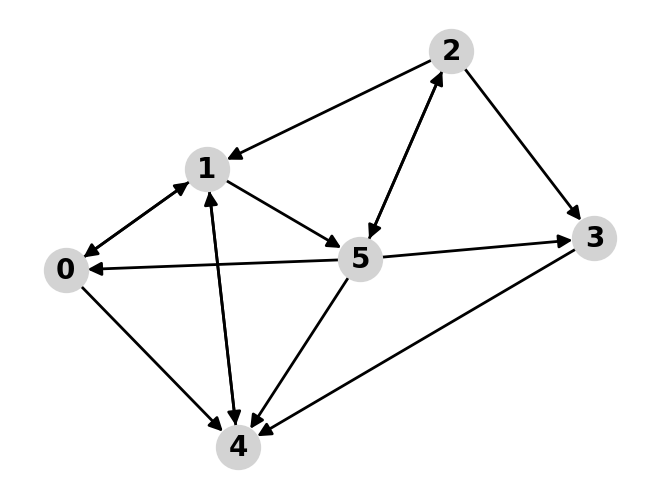

[[0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 0.]]
[[ 0. 12.  0.  0.  0.  8.]
 [ 8.  0. 13.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  9.]
 [ 0.  0.  4.  0.  0. 11.]
 [ 5. 17.  0. 14.  0. 18.]
 [ 0.  0.  3.  0.  0.  0.]]


In [36]:
draw_nwgraph(cmat)

print(cmat)
print(dmat)

In [3]:
N = 6

cmat = np.array([[0., 1., 0., 0., 0., 1.],
 [1., 0., 1., 0., 1., 0.],
 [0., 0., 0., 0., 0., 1.],
 [0., 0., 1., 0., 0., 1.],
 [1., 1., 0., 1., 0., 1.],
 [0., 1., 1., 0., 0., 0.]])
dmat = np.array( [[ 0., 12.,  0.,  0.,  0.,  8.],
 [ 8.,  0., 13.,  0.,  1.,  0.],
 [ 0.,  0.,  0.,  0.,  0.,  9.],
 [ 0.,  0.,  4.,  0.,  0., 11.],
 [ 5., 17.,  0., 14.,  0., 18.],
 [ 0.,  0.,  3.,  0.,  0.,  0.]])

In [4]:
coupling_array = np.array( [0.4, 0.8] )

eext = np.arange(0., 3., 0.2)
iext = np.arange(0., 3., 0.2)

add_ind = 15000

In [5]:
### ASYNC STATE INITAL

eext = [1.6]
iext = [0.4]

data_sync = dict()

data_sync["control"] = [None, None, None]
data_sync["state"] = [None, None, None]
data_sync["init"] = [None, None]
data_sync["weights"] = np.ones((3))
data_sync["control_cost"] = np.zeros((3))
data_sync["sync_cost"] = np.zeros((3))

----------------------------------------------------------- 0
----------------------------------------------------------- 1
1.6 0.4


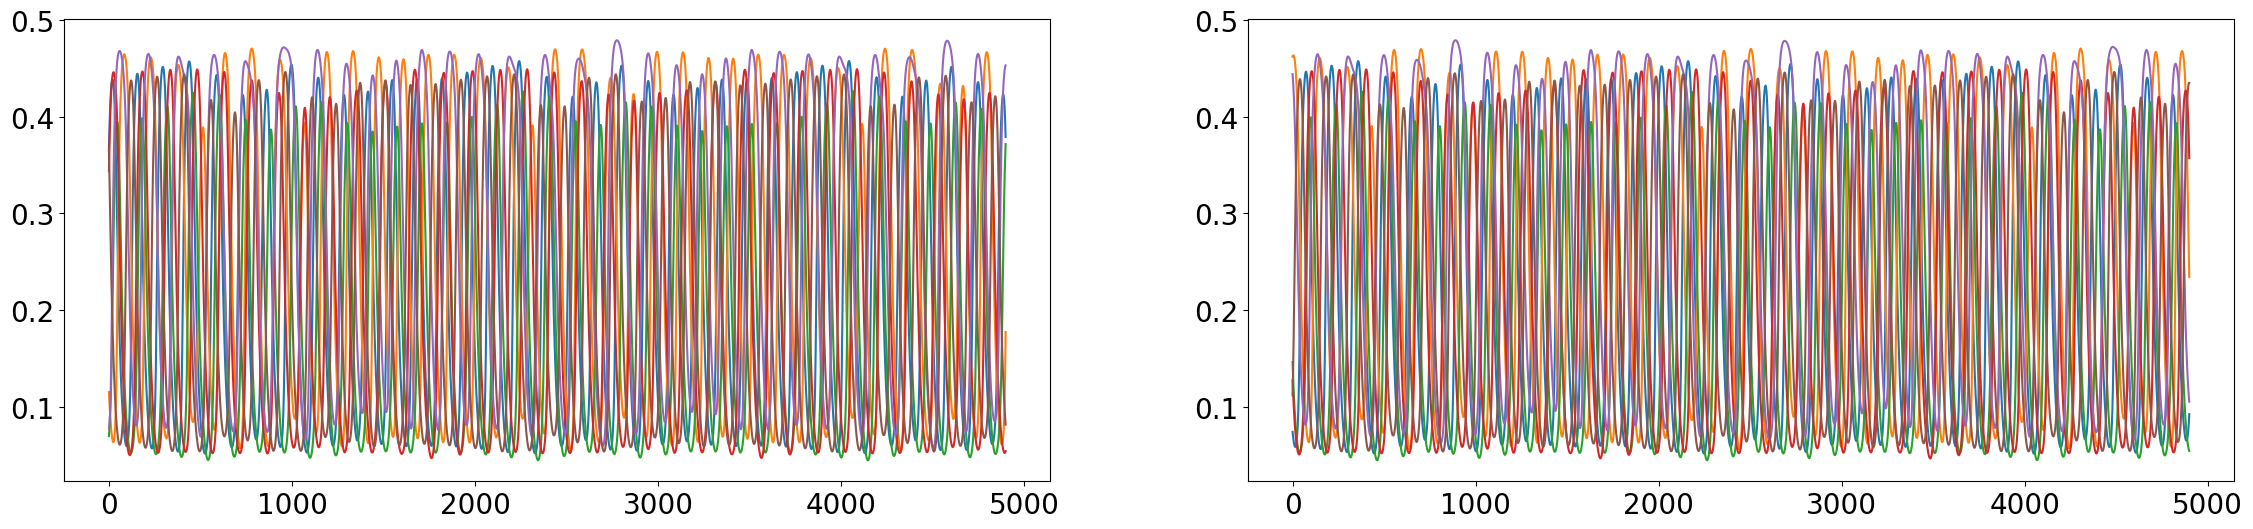

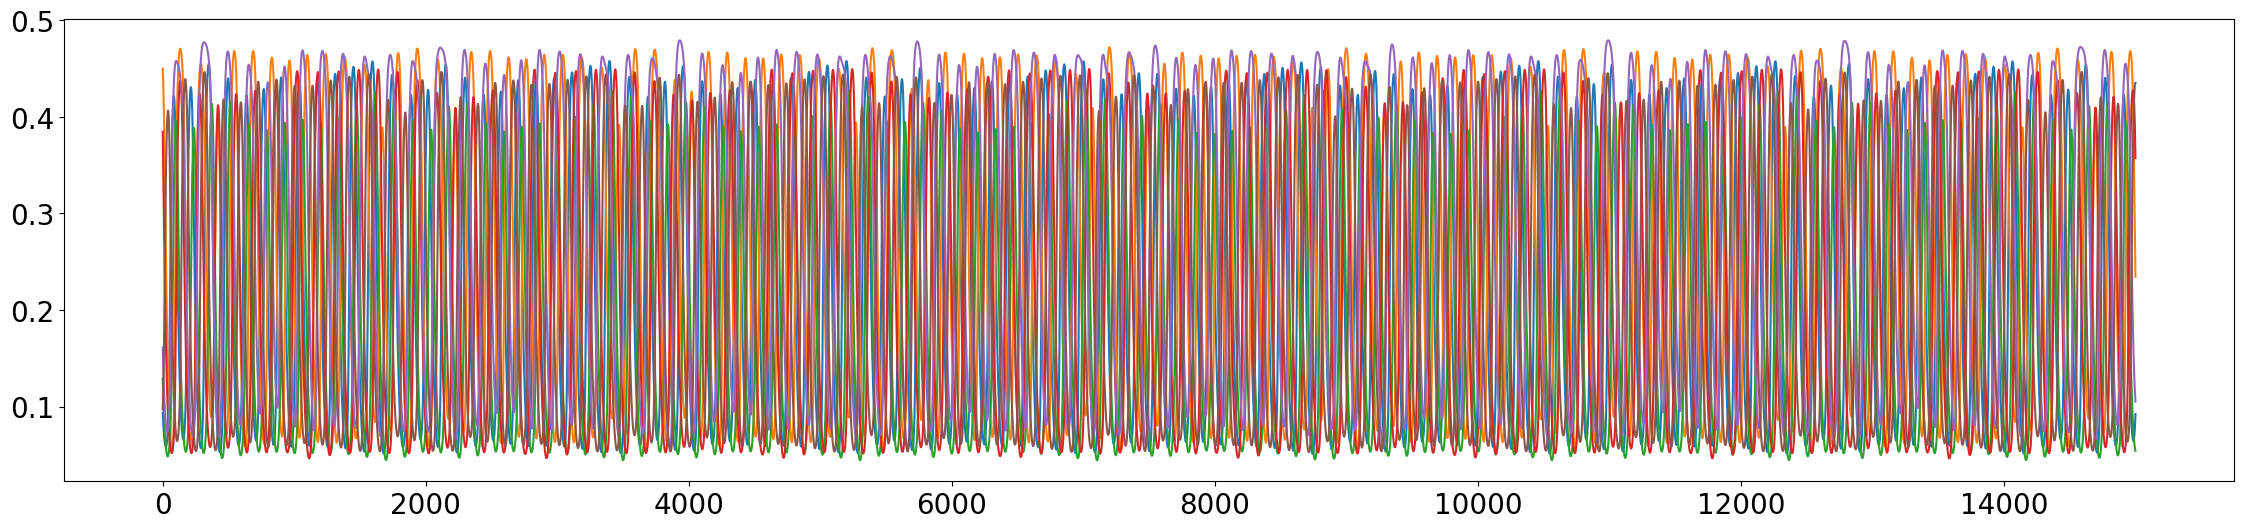

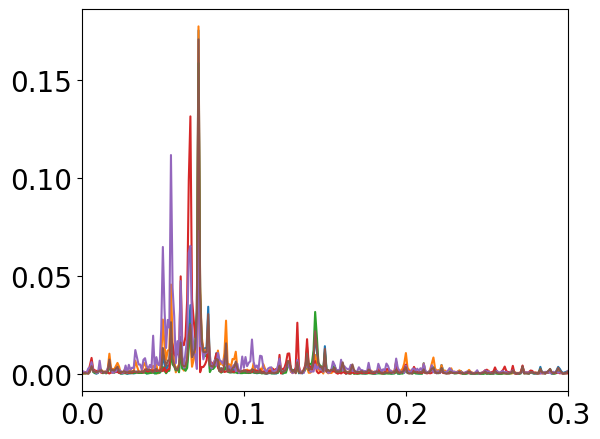

freq of max =  [0.0720144]
period of max =  [13.88611111]


In [6]:
for ci in range(len(coupling_array)):

    print("-----------------------------------------------------------", ci)

    if ci not in [1]: continue

    for e_ in eext:
        
        for i_ in iext:

            print(e_, i_)
        
            model = WCModel(Cmat=cmat, Dmat=dmat)
            model.params.K_gl = coupling_array[ci]
            dt = 0.1
            model.params.dt = dt

            dur = 4000.
            measure_dur = 30.
            i00, i01 = 0, 100
            i10, i11 = 20000, 20100

            model.params['duration'] = dur 
            test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
            test_input[:,i00:i01] = 6.
            test_input[:,i10:i11] = -6.
            model.params.exc_ext_baseline = e_
            model.params.inh_ext_baseline = i_
            model.params.exc_ext = test_input

            model.run()

            maxdelay = model.getMaxDelay()

            einit = np.zeros((N, maxdelay+1))
            iinit = np.zeros((N, maxdelay+1))

            for n in range(N):
                einit[n,:] = model.exc[n, -maxdelay-1:]
                iinit[n,:] = model.inh[n, -maxdelay-1:]

            data_sync["init"][0] = einit
            data_sync["init"][1] = iinit

            if np.var(model.exc[0,i01+add_ind:i10]) < 1e-6 and np.var(model.exc[0,i11+add_ind:]) < 1e-6:
                continue

            fig, ax = plt.subplots(1,2, figsize=(28,6))

            for n in range(N):
                ax[0].plot(model.exc[n,i01+add_ind:i10])
                ax[1].plot(model.exc[n,i11+add_ind:])

            plt.show()

            if True:

                fig, ax = plt.subplots(1,1, figsize=(28,6))
                for n in range(N):
                    ax.plot(model.exc[n,-add_ind:])
                plt.show()

                period_async = plotspectrum( [model.exc[0,-10000:], model.exc[1,-10000:], model.exc[2,-10000:], model.exc[3,-10000:], model.exc[4,-10000:], model.exc[5,-10000:]], fmax = 0.3)

In [7]:
### SYNC STATE INITAL

eext = [1.]
iext = [0.4]

data_desync = dict()

data_desync["control"] = [None, None, None]
data_desync["state"] = [None, None, None]
data_desync["init"] = [None, None]
data_desync["weights"] = np.ones((3))
data_desync["control_cost"] = np.zeros((3))
data_desync["sync_cost"] = np.zeros((3))

----------------------------------------------------------- 0
----------------------------------------------------------- 1
1.0 0.4


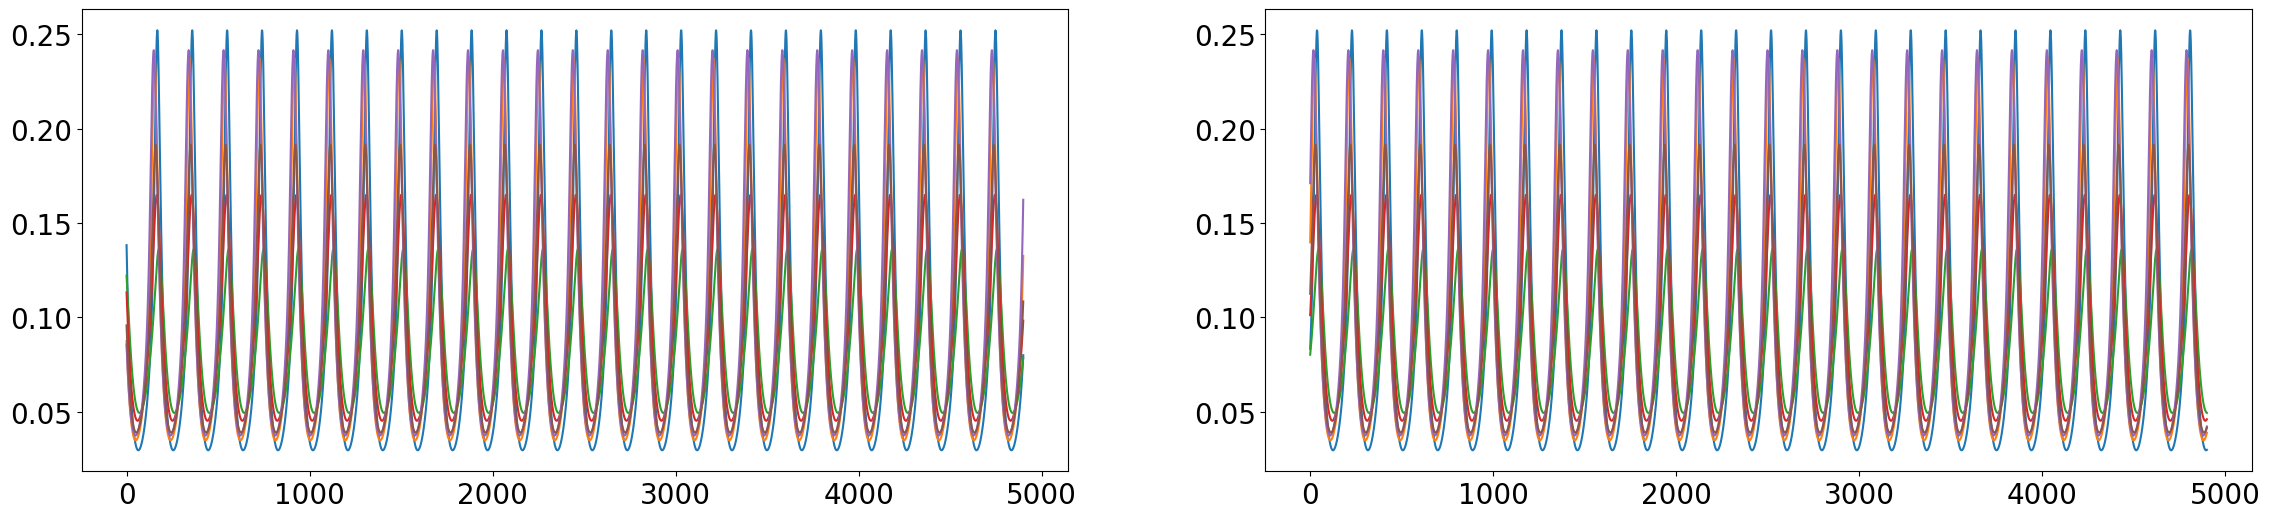

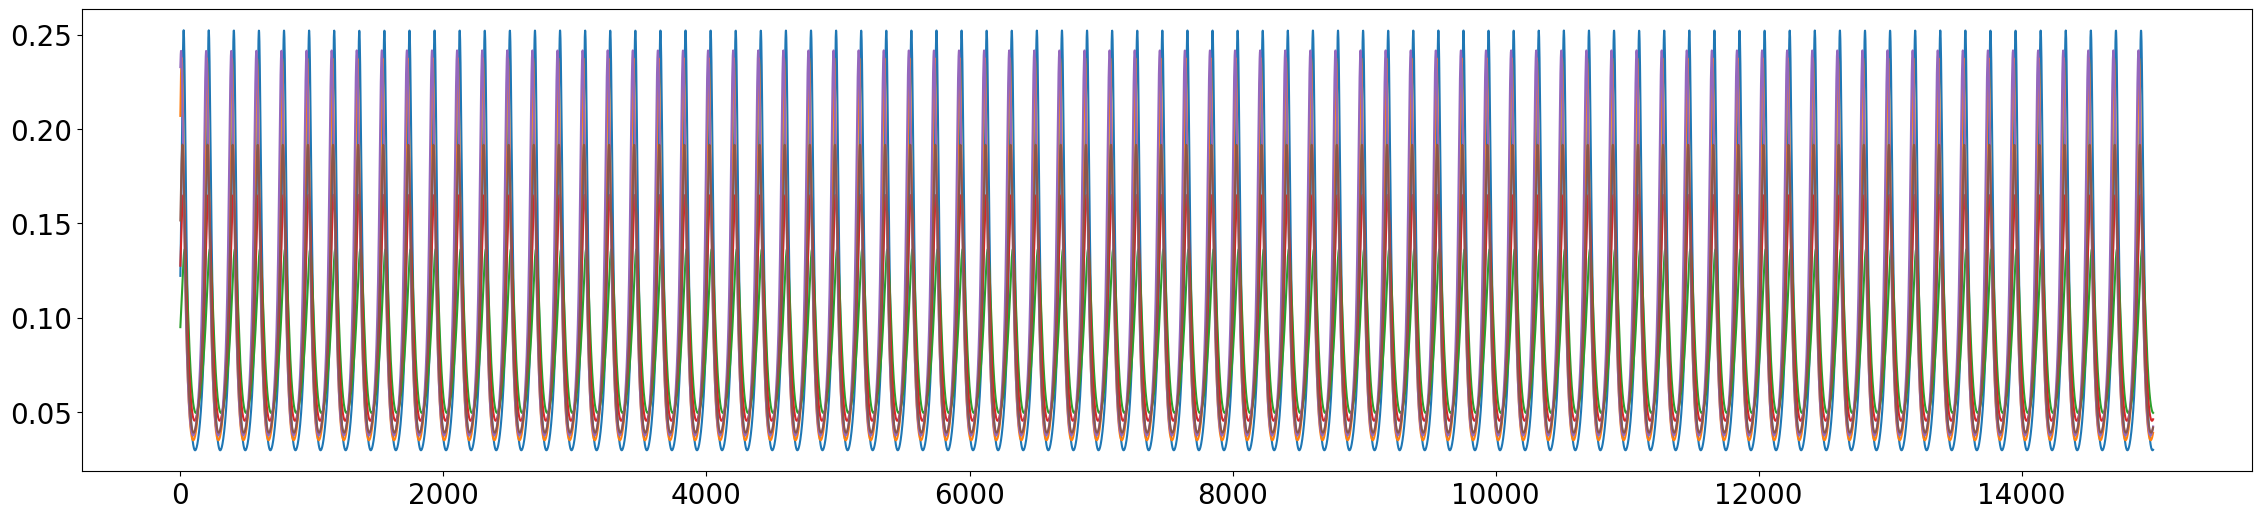

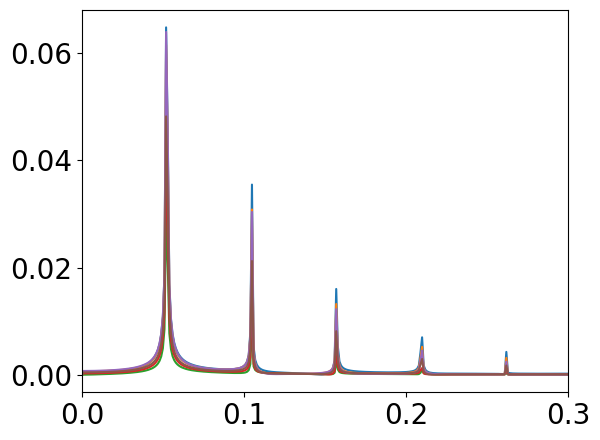

freq of max =  [0.0520104]
period of max =  [19.22692308]


In [8]:
for ci in range(len(coupling_array)):

    print("-----------------------------------------------------------", ci)

    if ci not in [1]: continue

    for e_ in eext:
        
        for i_ in iext:

            print(e_, i_)
        
            model = WCModel(Cmat=cmat, Dmat=dmat)
            model.params.K_gl = coupling_array[ci]
            dt = 0.1
            model.params.dt = dt

            dur = 4000.
            measure_dur = 30.
            i00, i01 = 0, 100
            i10, i11 = 20000, 20100

            model.params['duration'] = dur 
            test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
            test_input[:,i00:i01] = 6.
            test_input[:,i10:i11] = -6.
            model.params.exc_ext_baseline = e_
            model.params.inh_ext_baseline = i_
            model.params.exc_ext = test_input

            model.run()

            maxdelay = model.getMaxDelay()

            einit = np.zeros((N, maxdelay+1))
            iinit = np.zeros((N, maxdelay+1))

            for n in range(N):
                einit[n,:] = model.exc[n, -maxdelay-1:]
                iinit[n,:] = model.inh[n, -maxdelay-1:]

            data_desync["init"][0] = einit
            data_desync["init"][1] = iinit

            if np.var(model.exc[0,i01+add_ind:i10]) < 1e-6 and np.var(model.exc[0,i11+add_ind:]) < 1e-6:
                continue

            fig, ax = plt.subplots(1,2, figsize=(28,6))

            for n in range(N):
                ax[0].plot(model.exc[n,i01+add_ind:i10])
                ax[1].plot(model.exc[n,i11+add_ind:])

            plt.show()

            if True:

                fig, ax = plt.subplots(1,1, figsize=(28,6))
                for n in range(N):
                    ax.plot(model.exc[n,-add_ind:])
                plt.show()

                period_sync = plotspectrum( [model.exc[0,-10000:], model.exc[1,-10000:], model.exc[2,-10000:], model.exc[3,-10000:], model.exc[4,-10000:], model.exc[5,-10000:]], fmax = 0.3)

----------------------------------------------------------- 0
----------------------------------------------------------- 1
1.4 0.4


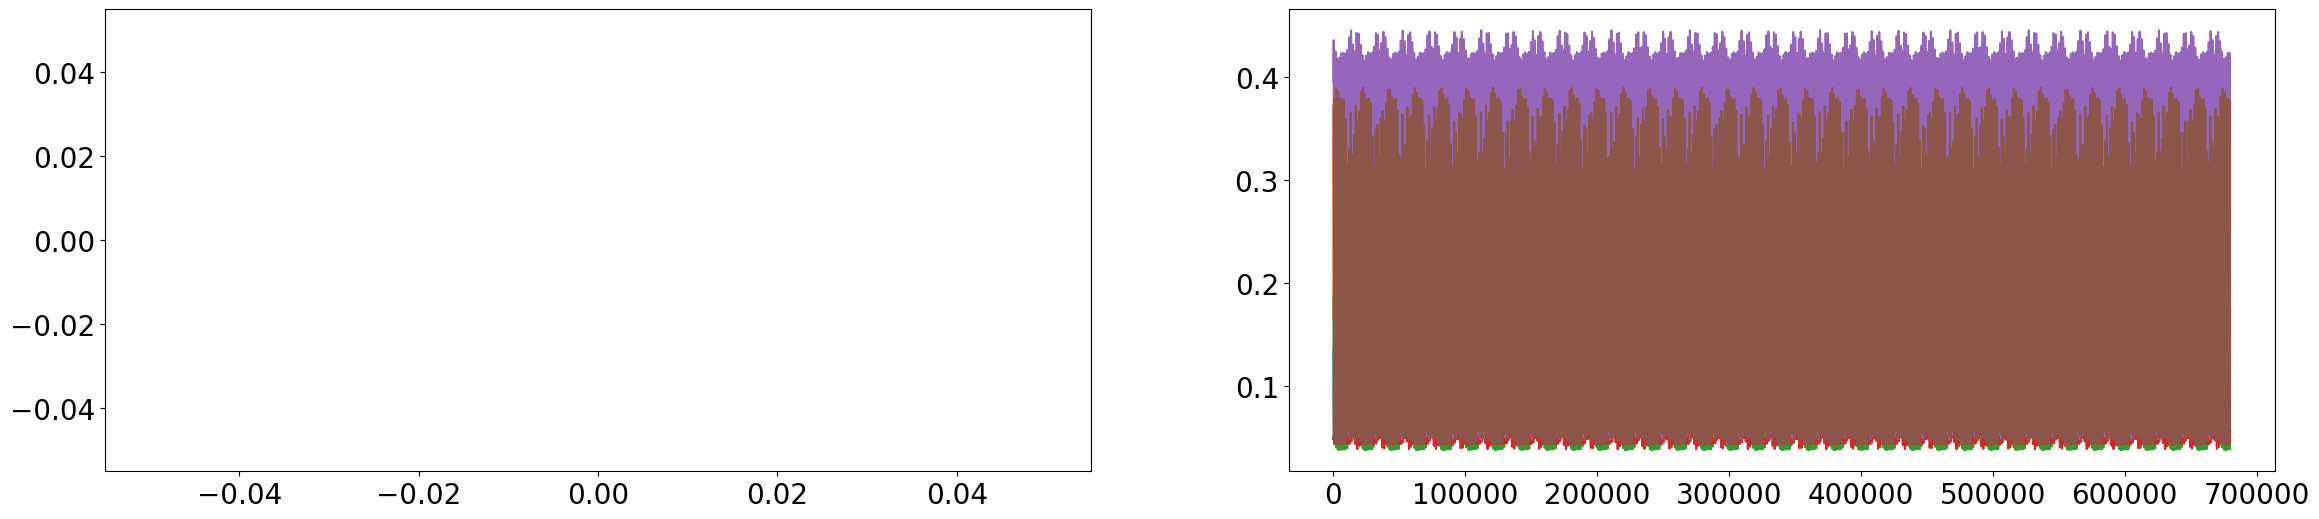

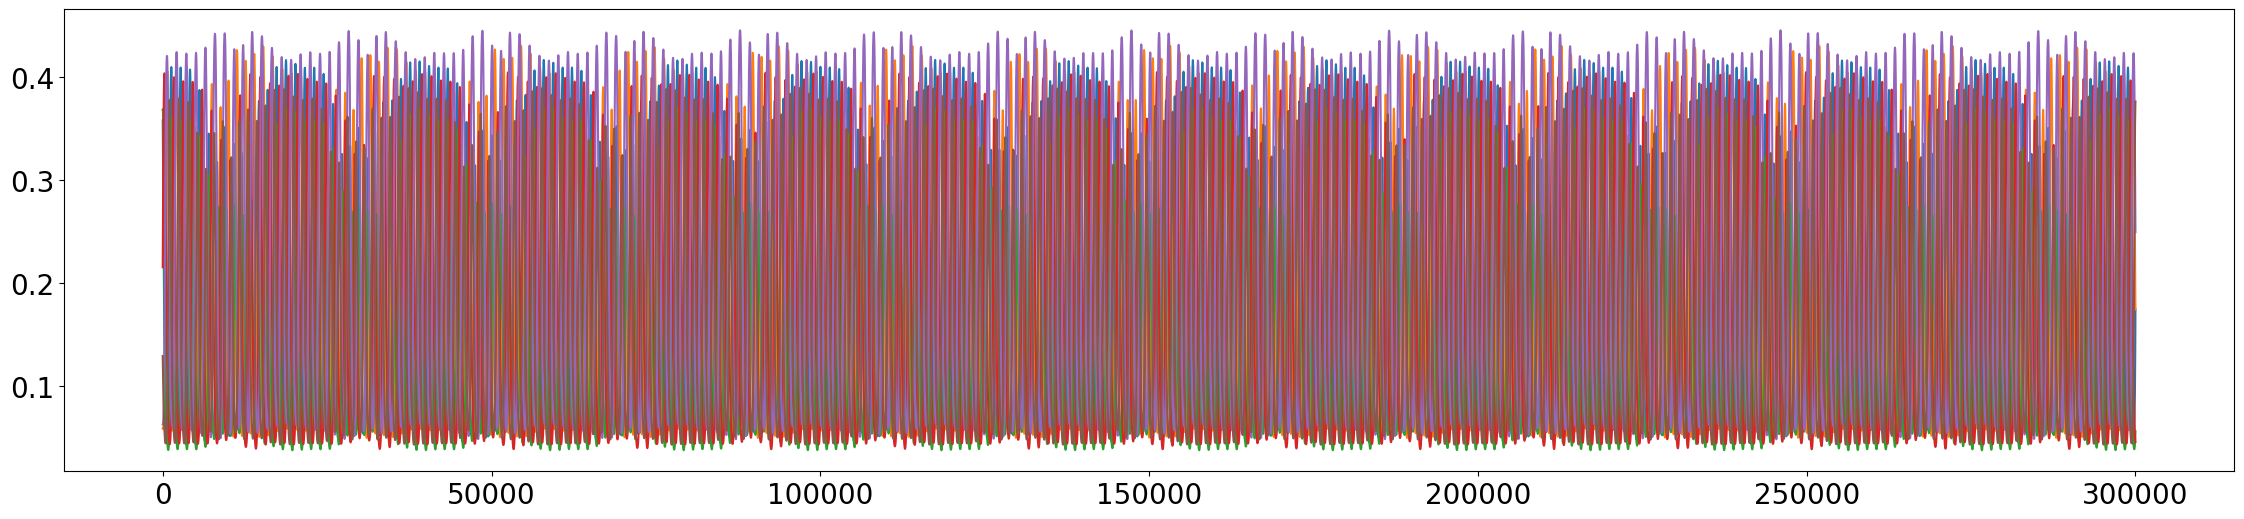

In [66]:
for ci in range(len(coupling_array)):

    print("-----------------------------------------------------------", ci)

    if ci not in [1]: continue

    for e_ in eext:
        
        for i_ in iext:

            print(e_, i_)
        
            model = WCModel(Cmat=cmat, Dmat=dmat)
            model.params.K_gl = coupling_array[ci]
            dt = 0.01
            model.params.dt = dt

            dur = 10000.

            model.params['duration'] = dur 
            test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
            model.params.exc_ext_baseline = e_
            model.params.inh_ext_baseline = i_

            model.run()

            add_ind = int(3000/dt)

            fig, ax = plt.subplots(1,2, figsize=(28,6))

            for n in range(N):
                ax[0].plot(model.exc[n,i01+add_ind:i10])
                ax[1].plot(model.exc[n,i11+add_ind:])
            plt.show()


            fig, ax = plt.subplots(1,1, figsize=(28,6))
            for n in range(N):
                ax.plot(model.exc[n,-add_ind:])
            plt.show()

In [9]:
weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [10]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1

costmat = np.zeros((N,2))
costmat[:,0] = 1

duration = 800
control_interval = [1000, -2000]
cost_interval = [1000, -2000]

maxstr = 5
pr = np.arange(0,501,10)

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [11]:
uncontrolled_state_sync = None
uncontrolled_cost_sync = np.zeros((3))

In [19]:
print(data_sync["weights"])
print(data_desync["weights"])

[  517.  4711. 45000.]
[1. 1. 1.]


In [13]:
data_sync["weights"][0] = 517 #200 zu hoch, 52115 zu niedrig, 52118.9832 zu hoch, 118.98319 zu niedrig
data_sync["weights"][1] = 4711
data_sync["weights"][2] = 45000

# few it with 52200, then reduce to 515

In [ ]:
data_sync["weights"][0] *= 36
data_desync["weights"][0] *= 36

print(data_sync["weights"])
print(data_desync["weights"])

In [21]:
it = 10


#############################################
#############################################
# WEIGHTS
#############################################
#############################################

model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling_array[1]
dt = 0.1
model.params.dt = dt

model.params['duration'] = duration
model.params.exc_ext_baseline = 1.6
model.params.inh_ext_baseline = 0.4

model.params["exc_ext"] = zero_control[:,0,:]
model.params["inh_ext"] = zero_control[:,1,:]

model.params["exc_init"] = data_sync["init"][0]
model.params["inh_init"] = data_sync["init"][1]

model.run()

uncontrolled_state_sync = [model.exc, model.inh]

for mi, method in enumerate(["F", "CC", "VAR"]):

    print("--------------------------------------- ", method)

    #if mi not in [0]: continue

    #data_sync["weights"][mi] = 0.0025

    model_controlled = oc_wc.OcWc(model, period_async, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                cost_matrix=costmat, control_matrix=controlmat)
    
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = 1.
    if method == "F":
        model_controlled.weights["w_f_sync"] = data_sync["weights"][mi]
    elif method == "CC":
        model_controlled.weights["w_cc"] = data_sync["weights"][mi]
    elif method == "VAR":
        model_controlled.weights["w_var"] = data_sync["weights"][mi]

    model_controlled.maximum_control_strength = maxstr

    model_controlled.optimize(0)
    uncontrolled_cost_sync[mi] = model_controlled.cost_history[-1]*data_sync["weights"][mi]

    if True:
        if type(data_sync["control"][mi]) != type(None):
            model_controlled.control = data_sync["control"][mi].copy()
            model_controlled.update_input()

    model_controlled.optimize(0)

    for j in range(10):
        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True

        if False:
            coc = cost_functions.control_strength_cost(data_sync["control"][mi], weights, dt)
            data_sync["weights"][mi] *= 80./coc
            print("change weight to/ cost of control  ", data_sync["weights"][mi], coc)
            if method == "F":
                model_controlled.weights["w_f_sync"] = data_sync["weights"][mi]
            elif method == "CC":
                model_controlled.weights["w_cc"] = data_sync["weights"][mi]
            elif method == "VAR":
                model_controlled.weights["w_var"] = data_sync["weights"][mi]

        for l in range(1):
            for k in np.arange(-4., 7., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        model_controlled.grad_method = 1
        model_controlled.channelwise_optimization = True

        for l in range(1):
            for k in np.arange(-4., 7., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    print("gradient = ", np.amax(np.abs(model_controlled.gradient)))

    data_sync["control"][mi] = model_controlled.control.copy()
    data_sync["state"][mi] = model_controlled.get_xs()

    coc = cost_functions.control_strength_cost(data_sync["control"][mi], weights, dt)
    data_sync["control_cost"][mi] = coc
    data_sync["sync_cost"][mi] = (model_controlled.cost_history[-1] - coc)*data_sync["weights"][mi]

    print("cost of control = ", coc)
    print("cost sync = ", data_sync["sync_cost"][mi])
    plot_control(data_sync["control"][mi], data_sync["state"][mi], duration, dt)
    #plot_control(plot_c[:,:,1:], plot_s, mod.params.duration-dt, dt)

    with open(os.path.join(pickledir, '6n_sync.pickle'), 'wb') as f:
        pickle.dump(data_sync, f)

---------------------------------------  F
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.4822758967540206
Final cost : -1.4822758967540206
Compute control for a deterministic system
Cost in iteration 0: -19.22160475721175
Final cost : -19.22160475721175
Compute control for a deterministic system
Cost in iteration 0: -19.22160475721175
Converged in iteration 2 with cost -19.22160475721175
Final cost : -19.22160475721175
Compute control for a deterministic system
Cost in iteration 0: -19.22160475721175
Converged in iteration 2 with cost -19.22160475721175
Final cost : -19.22160475721175
Compute control for a deterministic system
Cost in iteration 0: -19.22160475721175
Converged in iteration 2 with cost -19.22160475721175
Final cost : -19.22160475721175
Compute control for a deterministic system
Cost in iteration 0: -19.22160475721175
Converged in iteration 2 with cost -19.22160475721175
Final cost : -19.22160475721175
Co

In [14]:
with open(os.path.join(pickledir, '6n_sync.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data_sync = res_read.copy()

dict_keys(['control', 'state', 'init', 'weights', 'control_cost', 'sync_cost'])


In [284]:
uncontrolled_state_desync = None
uncontrolled_cost_desync = np.zeros((3))

---------------------------------------  F
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 3.45147473953685e-06
Final cost : 3.45147473953685e-06


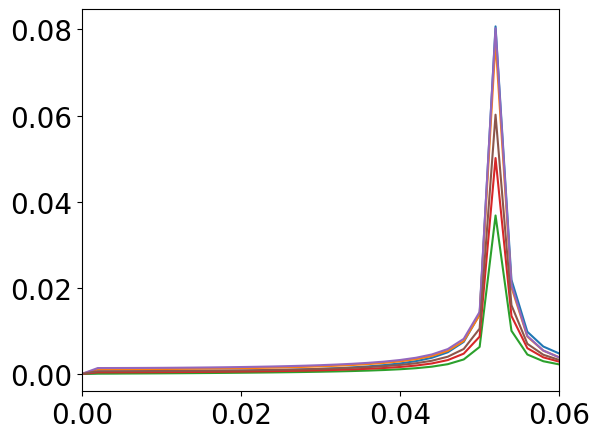

freq of max =  [0.05202081]
period of max =  [19.22307692]


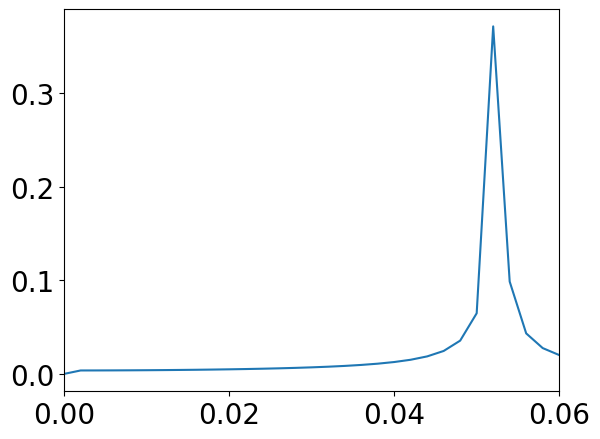

freq of max =  [0.05202081]
period of max =  [19.22307692]
Compute control for a deterministic system
Cost in iteration 0: 0.010291366622643482
Final cost : 0.010291366622643482


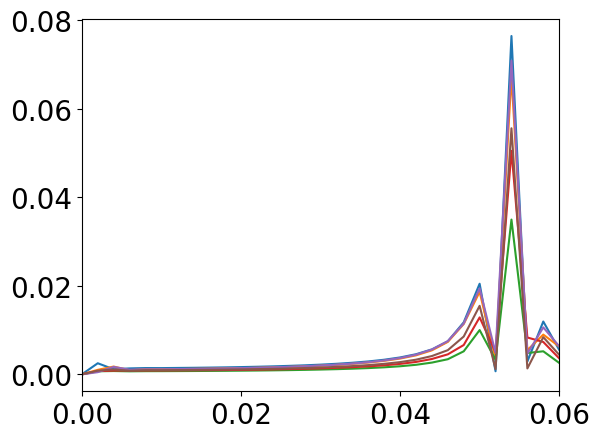

freq of max =  [0.05402161]
period of max =  [18.51111111]


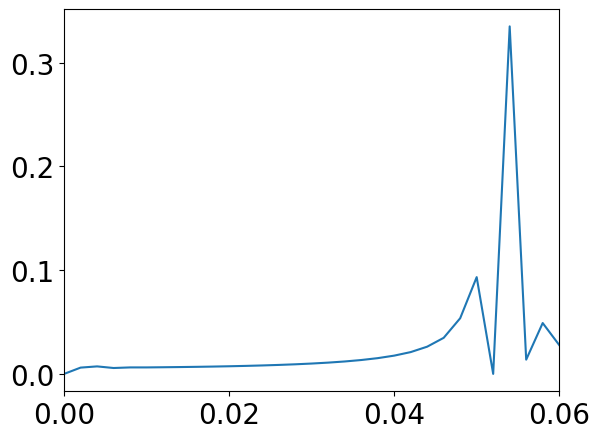

freq of max =  [0.05402161]
period of max =  [18.51111111]
gradient =  0.0
cost of control =  0.010291366622641804
cost sync =  1.0287915147902268e-06


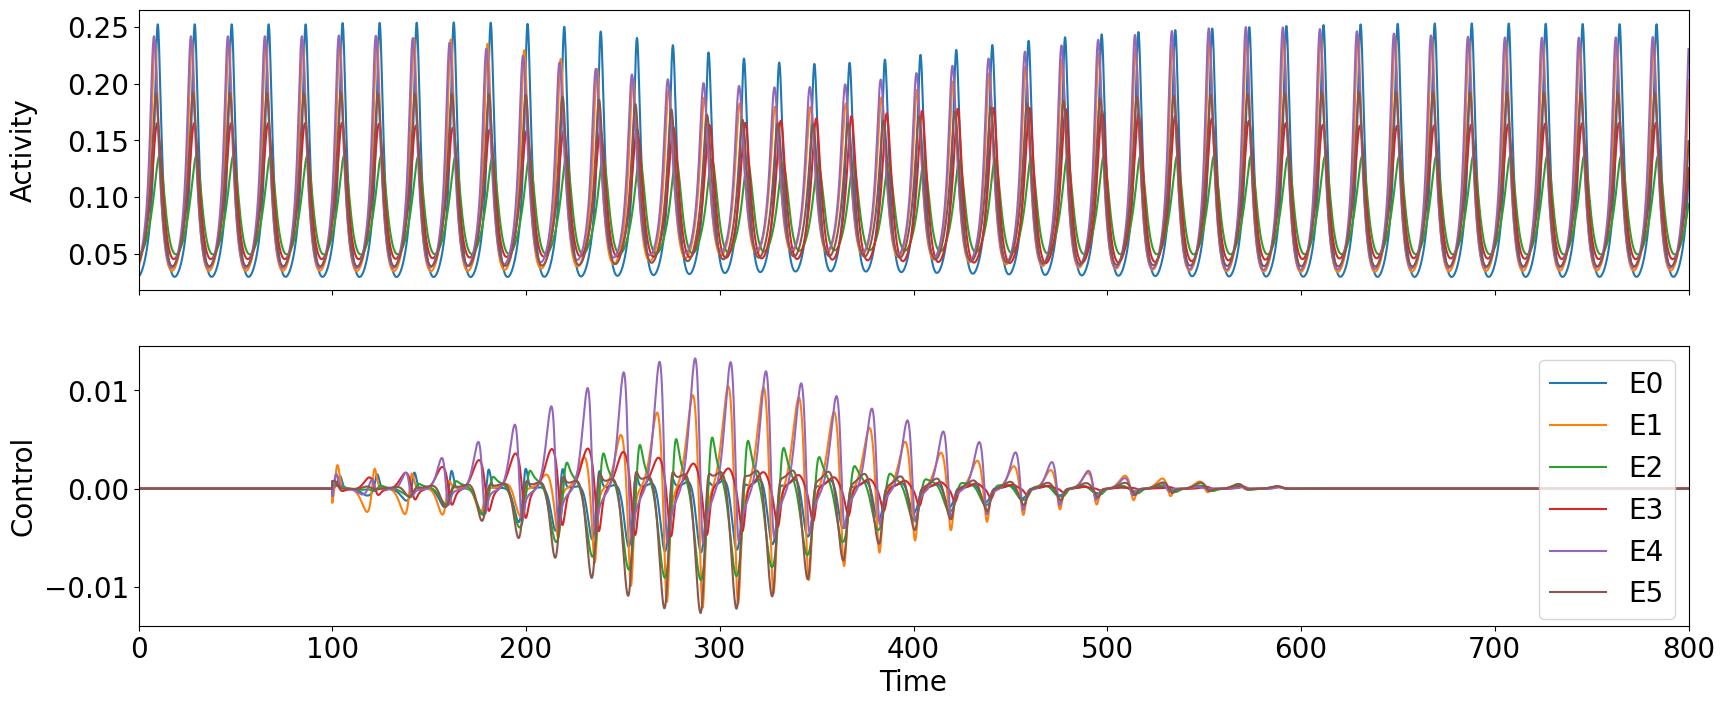

---------------------------------------  CC
---------------------------------------  VAR


In [287]:
it = 10

model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling_array[1]
dt = 0.1
model.params.dt = dt

model.params['duration'] = duration
model.params.exc_ext_baseline = 1.
model.params.inh_ext_baseline = 0.4

model.params["exc_ext"] = zero_control[:,0,:]
model.params["inh_ext"] = zero_control[:,1,:]

model.params["exc_init"] = data_desync["init"][0]
model.params["inh_init"] = data_desync["init"][1]

model.run()

uncontrolled_state_desync = [model.exc, model.inh]

for mi, method in enumerate(["F", "CC", "VAR"]):

    print("--------------------------------------- ", method)

    if mi not in [0]: continue

    #data_desync["weights"][mi] = 0.0001

    model_controlled = oc_wc.OcWc(model, period_sync, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                cost_matrix=costmat, control_matrix=controlmat)
    
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = 1.
    if method == "F":
        model_controlled.weights["w_f_sync"] = -data_desync["weights"][mi]
    elif method == "CC":
        model_controlled.weights["w_cc"] = -data_desync["weights"][mi]
    elif method == "VAR":
        model_controlled.weights["w_var"] = -data_desync["weights"][mi]

    model_controlled.maximum_control_strength = maxstr

    model_controlled.optimize(0)
    uncontrolled_cost_desync[mi] = (-1) * (model_controlled.cost_history[-1] )*data_desync["weights"][mi]

    plotspectrum([model_controlled.get_xs()[0,0,control_interval[0]:control_interval[1]],model_controlled.get_xs()[1,0,control_interval[0]:control_interval[1]],
                  model_controlled.get_xs()[2,0,control_interval[0]:control_interval[1]],model_controlled.get_xs()[3,0,control_interval[0]:control_interval[1]],
                  model_controlled.get_xs()[4,0,control_interval[0]:control_interval[1]],model_controlled.get_xs()[5,0,control_interval[0]:control_interval[1]]], fmax=0.06)
    plotspectrum([model_controlled.get_xs()[0,0,control_interval[0]:control_interval[1]] + model_controlled.get_xs()[1,0,control_interval[0]:control_interval[1]]
                  +model_controlled.get_xs()[2,0,control_interval[0]:control_interval[1]]+model_controlled.get_xs()[3,0,control_interval[0]:control_interval[1]]
                  +model_controlled.get_xs()[4,0,control_interval[0]:control_interval[1]]+model_controlled.get_xs()[5,0,control_interval[0]:control_interval[1]]], fmax=0.06)

    if True:
        if type(data_desync["control"][mi]) != type(None):
            model_controlled.control = data_desync["control"][mi].copy()
            model_controlled.update_input()

    model_controlled.optimize(0)
    plotspectrum([model_controlled.get_xs()[0,0,control_interval[0]:control_interval[1]],model_controlled.get_xs()[1,0,control_interval[0]:control_interval[1]],
                  model_controlled.get_xs()[2,0,control_interval[0]:control_interval[1]],model_controlled.get_xs()[3,0,control_interval[0]:control_interval[1]],
                  model_controlled.get_xs()[4,0,control_interval[0]:control_interval[1]],model_controlled.get_xs()[5,0,control_interval[0]:control_interval[1]]], fmax=0.06)
    plotspectrum([model_controlled.get_xs()[0,0,control_interval[0]:control_interval[1]] + model_controlled.get_xs()[1,0,control_interval[0]:control_interval[1]]
                  +model_controlled.get_xs()[2,0,control_interval[0]:control_interval[1]]+model_controlled.get_xs()[3,0,control_interval[0]:control_interval[1]]
                  +model_controlled.get_xs()[4,0,control_interval[0]:control_interval[1]]+model_controlled.get_xs()[5,0,control_interval[0]:control_interval[1]]], fmax=0.06)

    for j in range(0):
        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True

        for l in range(1):
            for k in np.arange(-3., 6., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        model_controlled.grad_method = 1
        model_controlled.channelwise_optimization = True

        for l in range(1):
            for k in np.arange(-4., 5., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    print("gradient = ", np.amax(np.abs(model_controlled.gradient)))

    data_desync["control"][mi] = model_controlled.control.copy()
    data_desync["state"][mi] = model_controlled.get_xs()

    coc = cost_functions.control_strength_cost(data_desync["control"][mi], weights, dt)
    data_desync["control_cost"][mi] = coc
    data_desync["sync_cost"][mi] = (-1) * (model_controlled.cost_history[-1] - coc)*data_desync["weights"][mi]

    print("cost of control = ", coc)
    print("cost sync = ", data_desync["sync_cost"][mi])
    plot_control(data_desync["control"][mi], data_desync["state"][mi], duration, dt)
    #plot_control(plot_c[:,:,1:], plot_s, mod.params.duration-dt, dt)

    with open(os.path.join(pickledir, '6n_desync.pickle'), 'wb') as f:
        pickle.dump(data_desync, f)

In [285]:
with open(os.path.join(pickledir, '6n_desync.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data_desync = res_read.copy()

dict_keys(['control', 'state', 'init', 'weights', 'control_cost', 'sync_cost'])


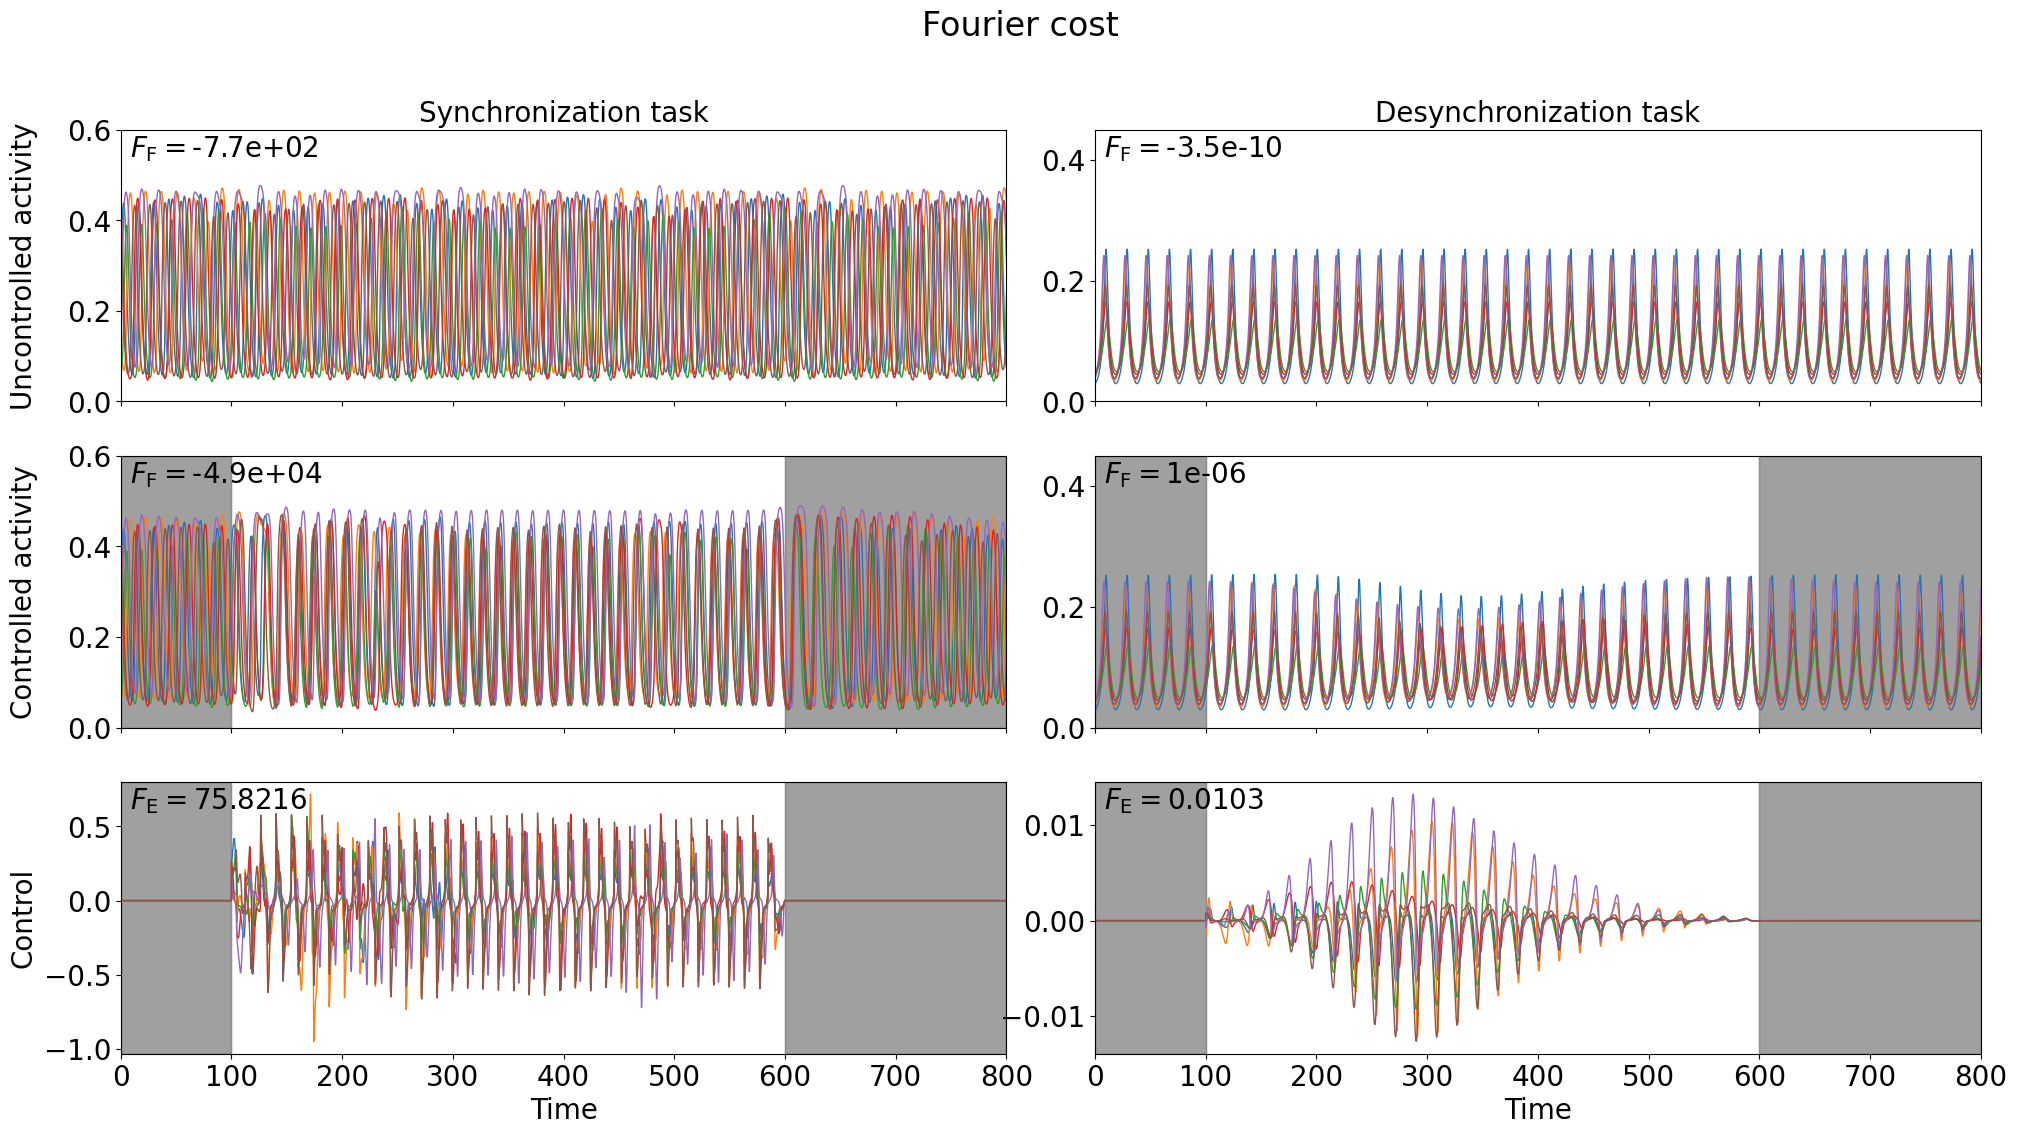

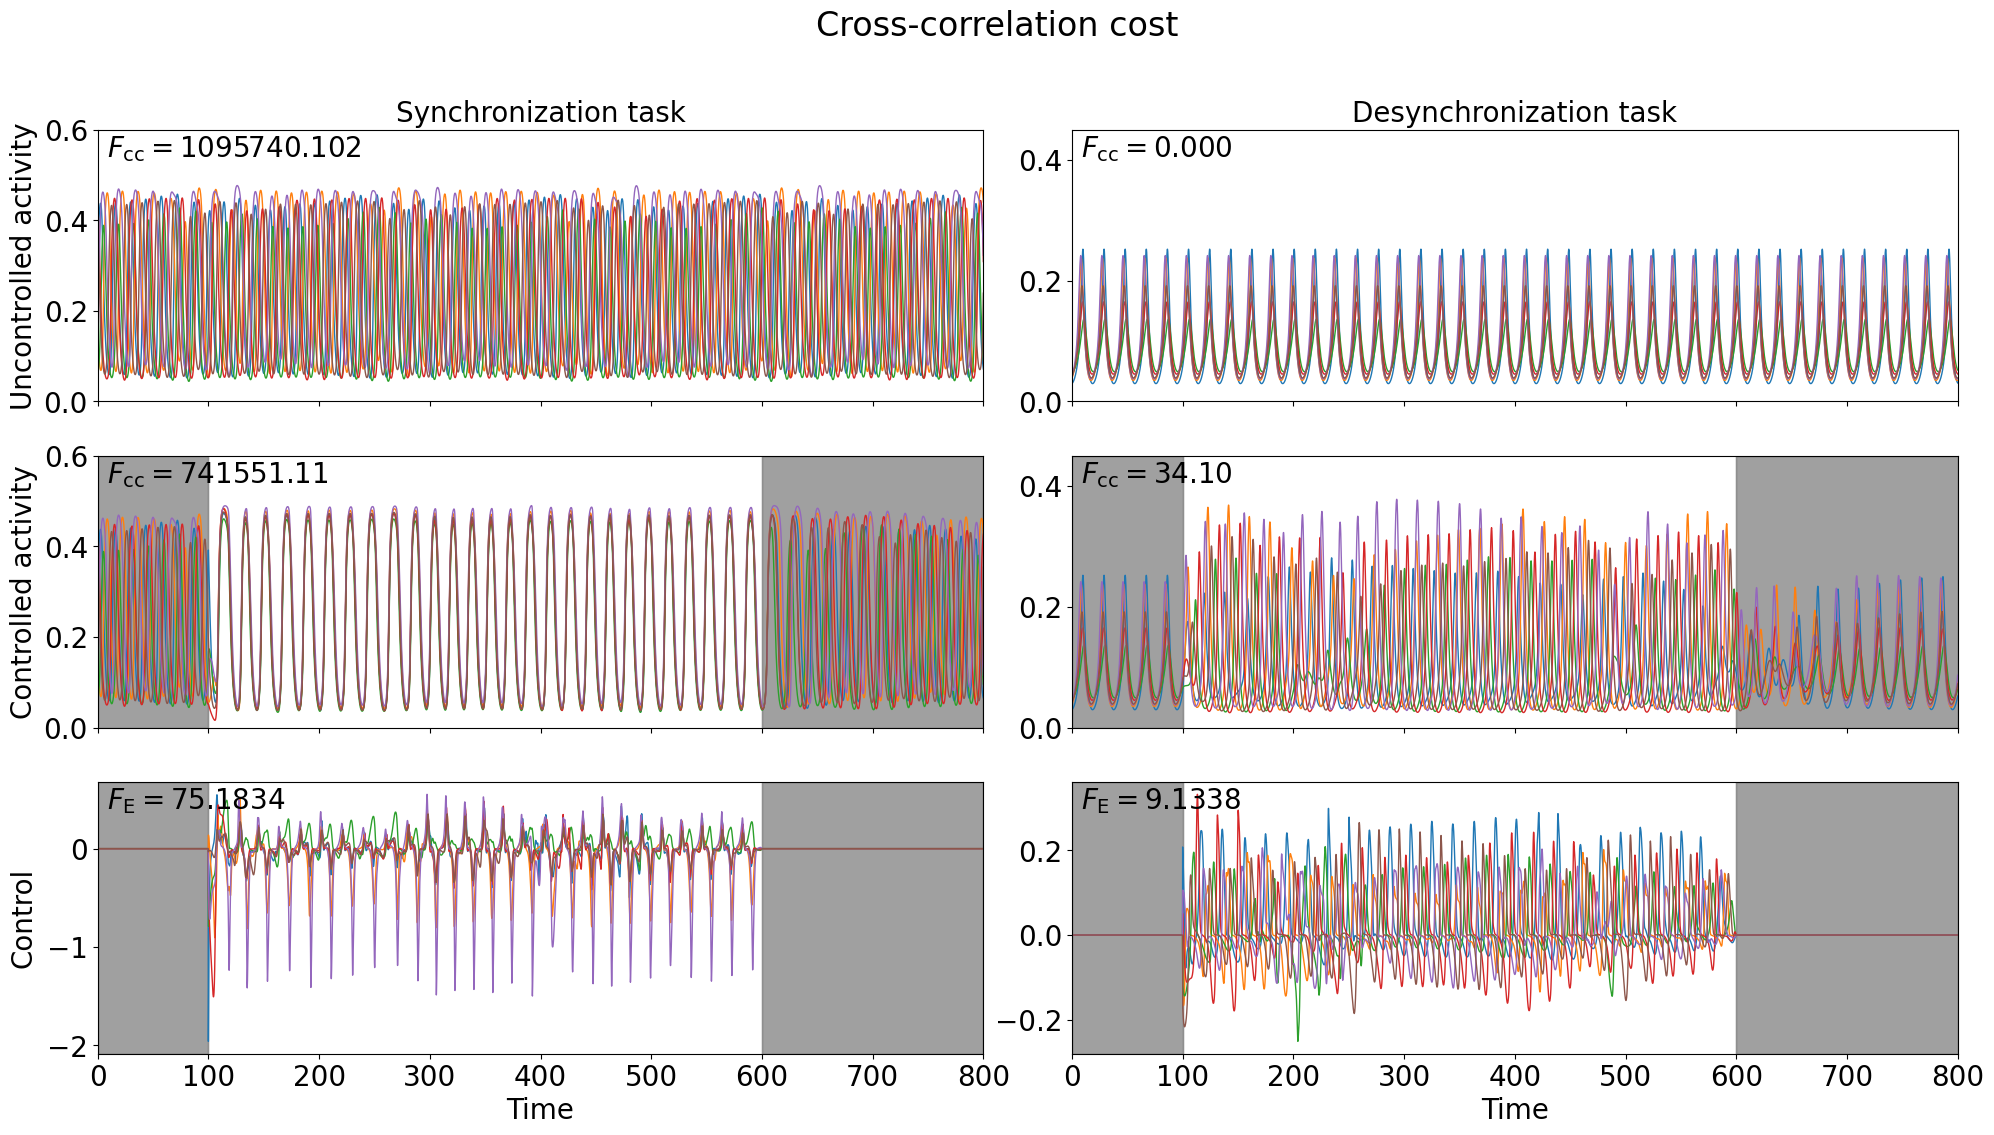

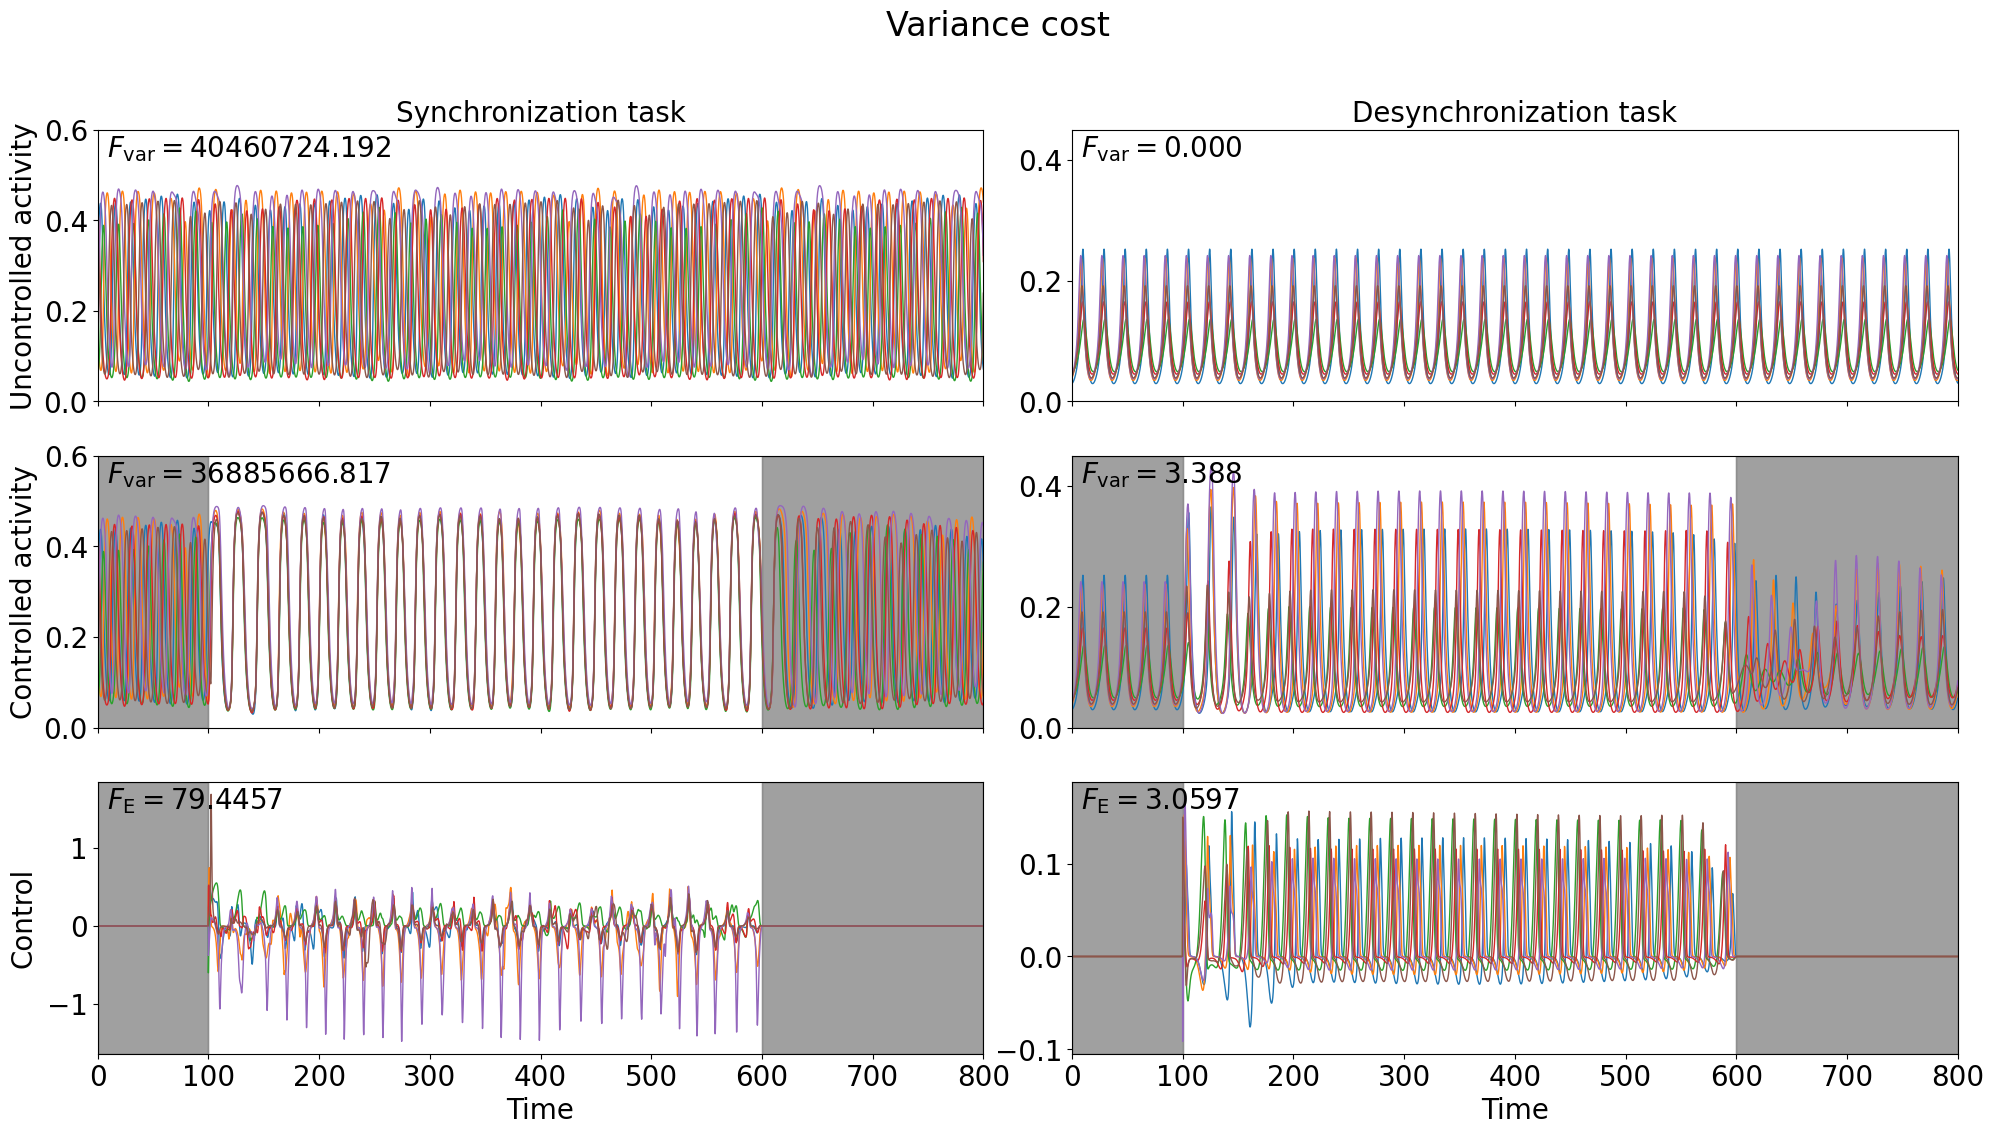

In [288]:
for mi in range(3):

    fig, ax = plt.subplots(3, 2, figsize=(24,12), sharex=True)

    time = np.arange(0, duration+dt, dt)

    for n in range(N):
        ax[0,0].plot(time[1:], uncontrolled_state_sync[0][n,:], linewidth=1)
        ax[0,1].plot(time[1:], uncontrolled_state_desync[0][n,:], linewidth=1)
        ax[1,0].plot(time, data_sync["state"][mi][n,0,:], linewidth=1)
        ax[1,1].plot(time, data_desync["state"][mi][n,0,:], linewidth=1)
        ax[2,0].plot(time, data_sync["control"][mi][n,0,:], linewidth=1)
        ax[2,1].plot(time, data_desync["control"][mi][n,0,:], linewidth=1)

        ax[1,0].axvspan(0, 100, color="grey", alpha=0.2)
        ax[1,0].axvspan(600, 800, color="grey", alpha=0.2)
        ax[1,1].axvspan(0, 100, color="grey", alpha=0.2)
        ax[1,1].axvspan(600, 800, color="grey", alpha=0.2)

        ax[2,0].axvspan(0, 100, color="grey", alpha=0.2)
        ax[2,0].axvspan(600, 800, color="grey", alpha=0.2)
        ax[2,1].axvspan(0, 100, color="grey", alpha=0.2)
        ax[2,1].axvspan(600, 800, color="grey", alpha=0.2)

    ax[0,0].set_title("Synchronization task")
    ax[0,1].set_title("Desynchronization task")

    xpos = 0.01
    ypos = 0.9

    if mi == 0:
        ax[0,0].text(xpos, ypos, r"$F_\text{F} = $" + "{0:.2g}".format(uncontrolled_cost_sync[mi]), transform=ax[0,0].transAxes)
        ax[0,1].text(xpos, ypos, r"$F_\text{F} = $" + "{0:.2g}".format(uncontrolled_cost_desync[mi]), transform=ax[0,1].transAxes)
        ax[1,0].text(xpos, ypos, r"$F_\text{F} = $" + "{0:0.2g}".format(data_sync["sync_cost"][mi]), transform=ax[1,0].transAxes)
        ax[1,1].text(xpos, ypos, r"$F_\text{F} = $" + "{0:0.2g}".format(data_desync["sync_cost"][mi]), transform=ax[1,1].transAxes)
    elif mi == 1:
        ax[0,0].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:.3f}".format(uncontrolled_cost_sync[mi]), transform=ax[0,0].transAxes)
        ax[0,1].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:.3f}".format(uncontrolled_cost_desync[mi]), transform=ax[0,1].transAxes)
        ax[1,0].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:0.2f}".format(data_sync["sync_cost"][mi]), transform=ax[1,0].transAxes)
        ax[1,1].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:0.2f}".format(data_desync["sync_cost"][mi]), transform=ax[1,1].transAxes)
    elif mi == 2:
        ax[0,0].text(xpos, ypos, r"$F_\text{var} = $" + "{0:.3f}".format(uncontrolled_cost_sync[mi]), transform=ax[0,0].transAxes)
        ax[0,1].text(xpos, ypos, r"$F_\text{var} = $" + "{0:.3f}".format(uncontrolled_cost_desync[mi]), transform=ax[0,1].transAxes)
        ax[1,0].text(xpos, ypos, r"$F_\text{var} = $" + "{0:0.3f}".format(data_sync["sync_cost"][mi]), transform=ax[1,0].transAxes)
        ax[1,1].text(xpos, ypos, r"$F_\text{var} = $" + "{0:0.3f}".format(data_desync["sync_cost"][mi]), transform=ax[1,1].transAxes)
        
    ax[2,0].text(xpos, ypos, r"$F_\text{E} = $" + "{:0.4f}".format(data_sync["control_cost"][mi]), transform=ax[2,0].transAxes)
    ax[2,1].text(xpos, ypos, r"$F_\text{E} = $" + "{:0.4f}".format(data_desync["control_cost"][mi]), transform=ax[2,1].transAxes)

    ax[0,0].set_ylim(0,0.6)
    ax[1,0].set_ylim(0,0.6)
    ax[0,1].set_ylim(0,0.45)
    ax[1,1].set_ylim(0,0.45)

    ax[0,0].set_xlim(0,duration)
    ax[2,0].set_xlabel("Time")
    ax[2,1].set_xlabel("Time")

    ax[0,0].set_ylabel("Uncontrolled activity")
    ax[1,0].set_ylabel("Controlled activity")
    ax[2,0].set_ylabel("Control")

    fig.align_ylabels([ax[:,0]])


    if mi == 0:
        fig.suptitle("Fourier cost")
    elif mi == 1:
        fig.suptitle("Cross-correlation cost")
    elif mi == 2:
        fig.suptitle("Variance cost")

    plt.subplots_adjust(wspace=0.1, 
                        hspace=0.2)

    plt.savefig(os.path.join(dir, "sync_desync" + str(mi) + ".pdf"), bbox_inches='tight')
    plt.show()



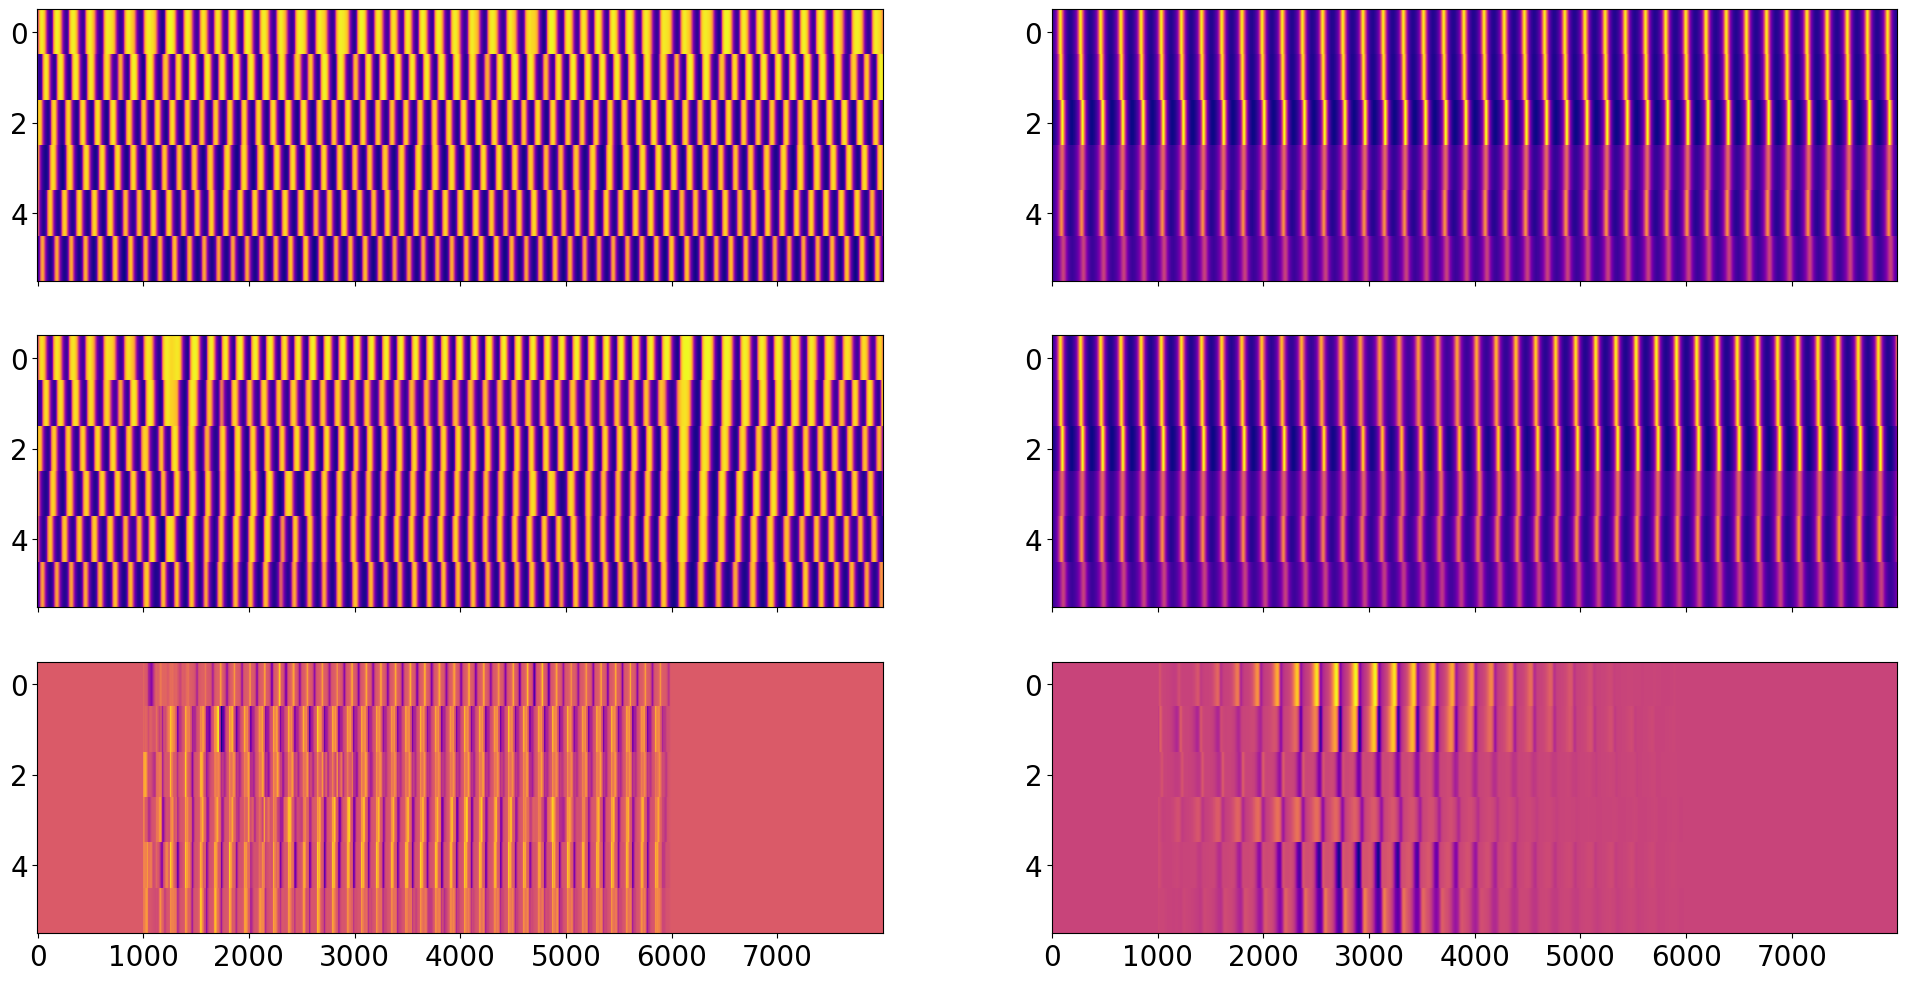

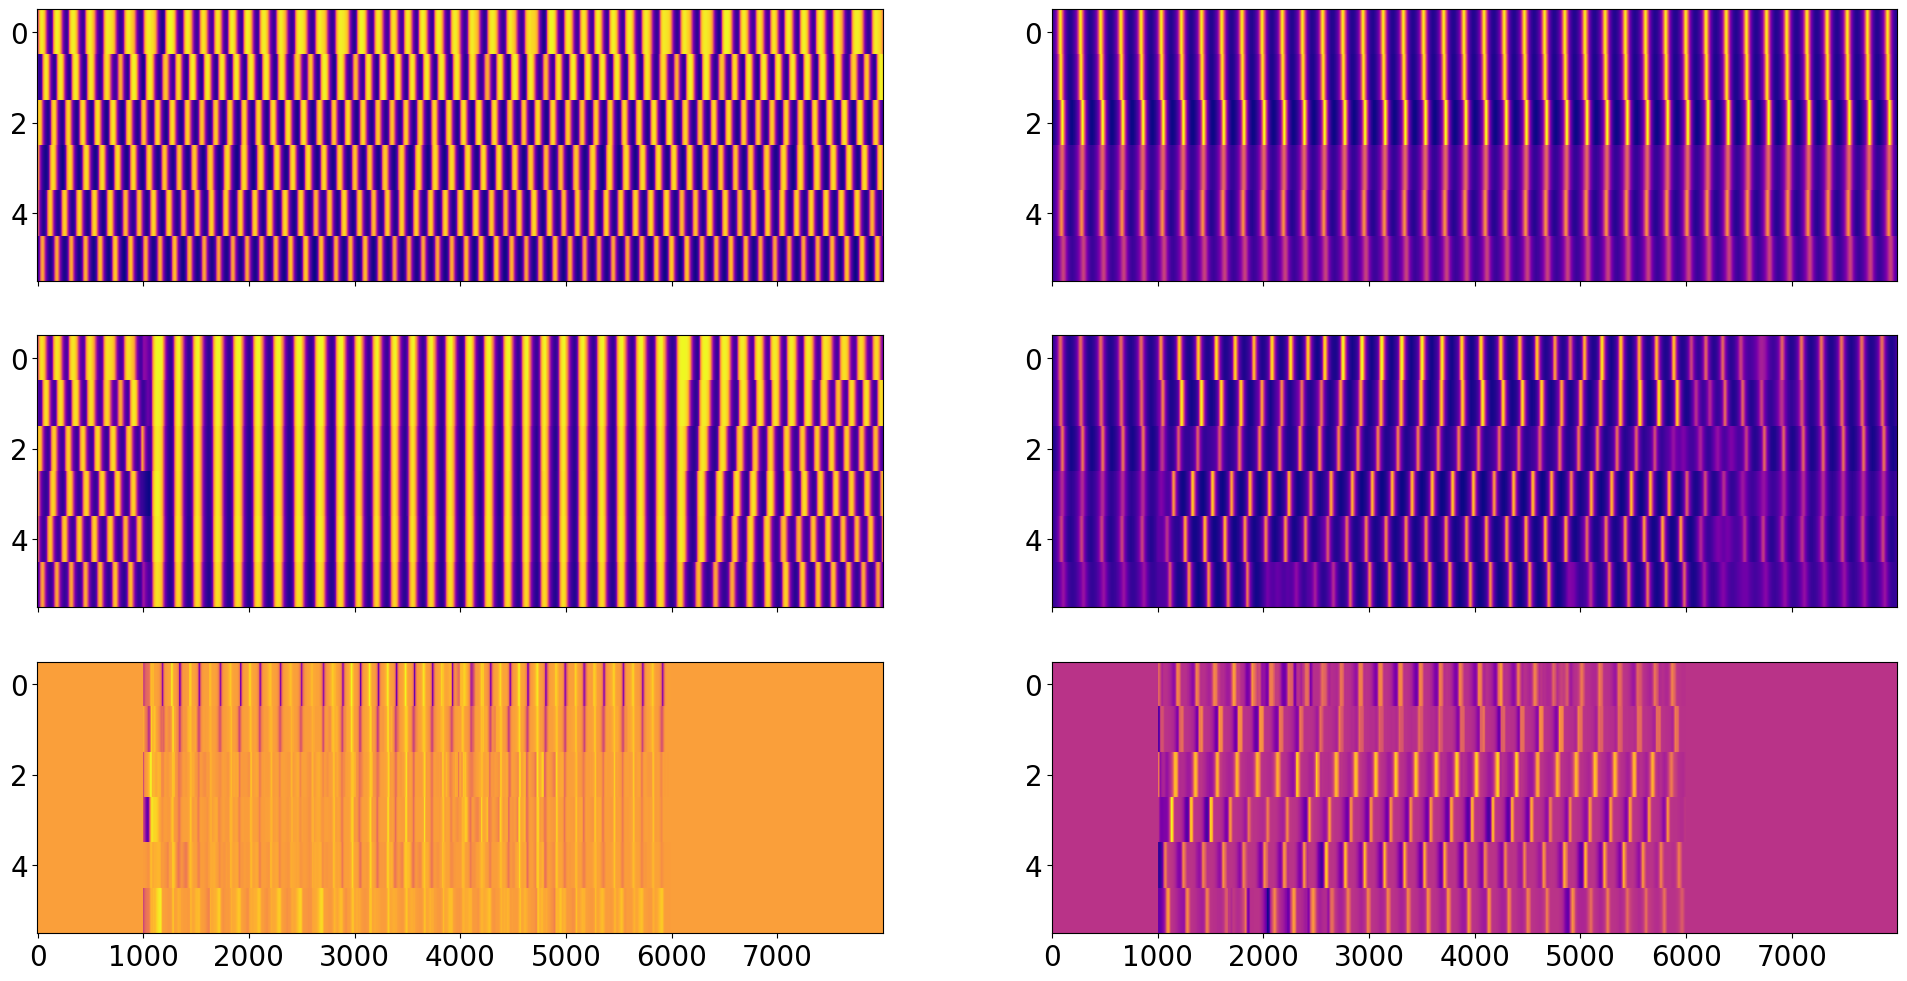

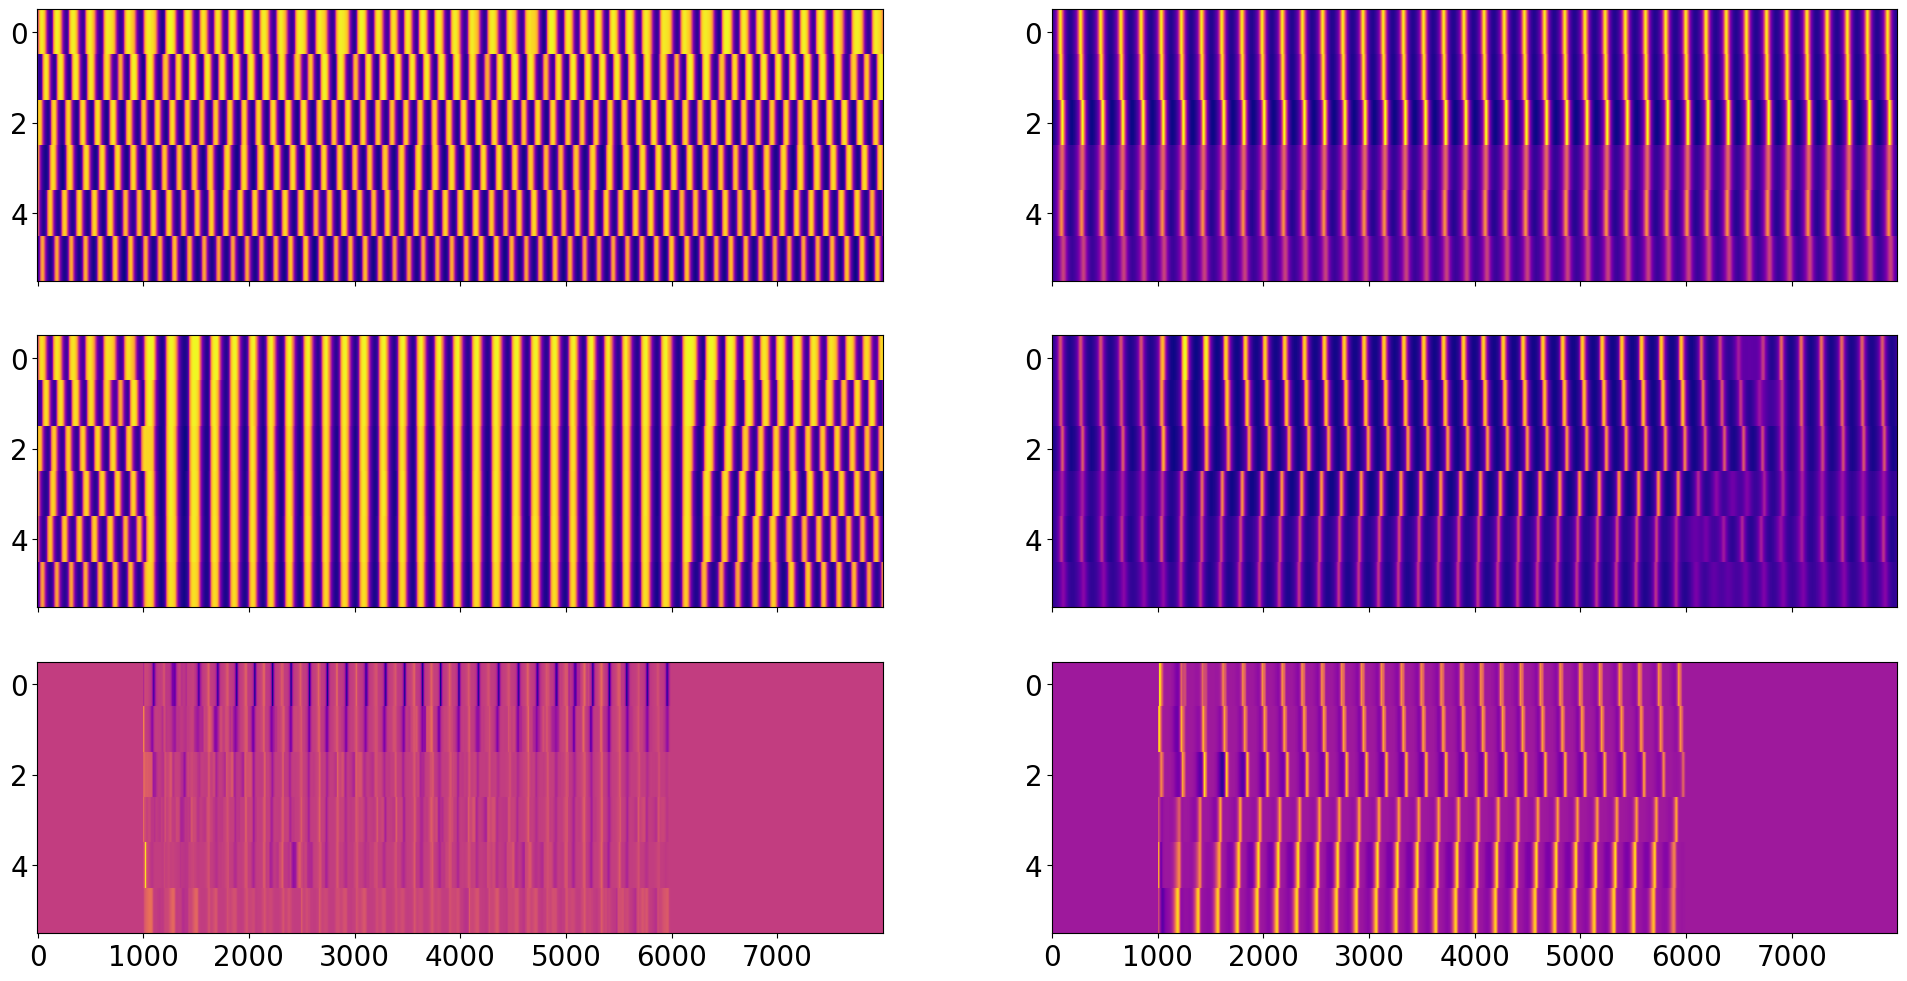

In [314]:
for mi in range(3):

    f,ax = plt.subplots(3,2, figsize=(24,12), sharex=True)
    time = np.arange(0, duration, dt)

    cmp = "plasma"
    heatmapdata = np.zeros((len(time), N))

    for n, re_orglist in zip([4, 1, 0, 3, 5, 2], range(N)):
        heatmapdata[:,re_orglist] = uncontrolled_state_sync[0][n,:]
    ax[0,0].imshow(heatmapdata.T, cmap=cmp, aspect='auto', interpolation="none")
    for n, re_orglist in zip([4, 1, 0, 3, 5, 2], range(N)):
        heatmapdata[:,re_orglist] = uncontrolled_state_desync[0][n,:]
    ax[0,1].imshow(heatmapdata.T, cmap=cmp, aspect='auto', interpolation="none")

    for n, re_orglist in zip([4, 1, 0, 3, 5, 2], range(N)):
        heatmapdata[:,re_orglist] = data_sync["state"][mi][n,0,1:]
    ax[1,0].imshow(heatmapdata.T, cmap=cmp, aspect='auto', interpolation="none")
    for n, re_orglist in zip([4, 1, 0, 3, 5, 2], range(N)):
        heatmapdata[:,re_orglist] = data_desync["state"][mi][n,0,1:]
    ax[1,1].imshow(heatmapdata.T, cmap=cmp, aspect='auto', interpolation="none")

    for n, re_orglist in zip([4, 1, 0, 3, 5, 2], range(N)):
        heatmapdata[:,re_orglist] = data_sync["control"][mi][n,0,1:]
    ax[2,0].imshow(heatmapdata.T, cmap=cmp, aspect='auto', interpolation="none")
    for n, re_orglist in zip([4, 1, 0, 3, 5, 2], range(N)):
        heatmapdata[:,re_orglist] = data_desync["control"][mi][n,0,1:]
    ax[2,1].imshow(heatmapdata.T, cmap=cmp, aspect='auto', interpolation="none")

    plt.show()

In [16]:
def plot_control(c, s, dur, dt):
    if dur < 1000:
        y1lim = [1.1 * np.amin(c[:,:,1:]), 1.1 * np.amax(c[:,:,1:])]
        fig, ax = plt.subplots(2,1, figsize=(20,8), sharex=True)
    else:
        y1lim = [1.1 * np.amin(c), 1.1 * np.amax(c)]
        fig, ax = plt.subplots(2,1, figsize=(28,8))

    time_array = np.arange(0, dur+dt, dt)

    for n in range(N):
        ax[0].plot(time_array,s[n,0,:], label="E{}".format(n))
        ax[1].plot(time_array, c[n,0,:], label="E{}".format(n))

    #ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right")

    ax[0].set_xlim(0, dur)
    ax[1].set_xlim(0, dur)
    #ax[0].set_ylim(y0lim)
    #ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")
    
    fig.align_ylabels([ax[:]])


    plt.show()
    return